# Question 2

Is there some (temporal) relation between the commenting activity and the decision to start "depending on" a package? For example, if you are a developer of some package, and you would like to start depending on another package, you might first start to be involved through comments in that package, before you actually make the decision to depend on it. Such a possible relation could probably be checked using the statistical technique of "survival analysis".

Data: In this part, we are going to use downloaded data (commit, pull request, commit comment, issue comment, pull review comments) of the selected list of repositories of cargo package manager for rust language. (99 github repositories)

In [1]:
import pandas
import matplotlib.pyplot as plt
import seaborn
import collections
import itertools
import numpy as np
import warnings
import subprocess
import requests
import lifelines


import sys
sys.path.append('..')

from helper import load_data , load_repo ,read_comments , GIT_API, DATE_RANGE
warnings.filterwarnings('ignore')

%matplotlib inline

palet = seaborn.color_palette('hls', 8)[0:8]
palet2 = seaborn.color_palette('GnBu_d', 8)[0:8]

#### Read all comments and select commented from contributors and collaborators and owners

In [2]:
all_comments = (
    read_comments()
    [lambda x: x['author_assoc'] != 'NONE']
    .assign(created_at= lambda x: pandas.to_datetime(x['created_at']))
)
all_comments.head()

,Name,user_login,author_assoc,created_at,type
1,itertools,bluss,OWNER,2017-09-05 21:42:56,cmt
2,itertools,DanielKeep,CONTRIBUTOR,2015-06-06 03:52:21,cmt
3,itertools,bluss,OWNER,2015-06-06 07:33:39,cmt
4,itertools,bluss,OWNER,2015-06-06 07:34:31,cmt
5,itertools,DanielKeep,CONTRIBUTOR,2015-06-06 07:43:55,cmt


#### Read Package dependencies with lifespan and elimination status

In [3]:
df_pckdpnd = (
    pandas.read_csv('../data/package_dependencies_time.csv.gz',compression='gzip',
                    parse_dates=['fst_release','lst_release','first_time','last_time'])
    .iloc[:,1:]
)
df_pckdpnd.shape

(48597, 10)

48597 package dependency

### Find contributors commented on a package before depending on it

In [4]:
cntb_cmnts = pandas.DataFrame()
new_data = pandas.DataFrame()
def check_comments(row):
    global cntb_cmnts
    global new_data
    contributors = all_comments[lambda x: x['Name'] == row['package']].user_login.unique()
    cont_depends = all_comments[lambda x: x['Name'] == row['target']][all_comments['user_login'].isin(contributors)][all_comments['created_at'] < row['first_time']]
    cntb_cmnts = cntb_cmnts.append(cont_depends.reset_index(),ignore_index=True)
    counter = collections.Counter(cont_depends.type.values)
    new_data = new_data.append({
                        "Name": row['package'],
                        "target": row['target'],
                        "contributor_commented_before_use": cont_depends.user_login.unique() if len(cont_depends)>0 else np.nan,
                        "Number_of_contributors": len(cont_depends.user_login.unique()),
                        "pulls": counter['pul'] if 'pul' in counter else 0,
                        "issues": counter['isu'] if 'isu' in counter else 0,
                        "commit": counter['cmt'] if 'cmt' in counter else 0,
                        "pullrq": counter['prq'] if 'prq' in counter else 0,
                        "comments_id": cont_depends.index.unique() if len(cont_depends)>0 else np.nan},ignore_index=True)
    return 1;
    

In [5]:
df_pckdpnd['done'] = df_pckdpnd.apply(lambda row: check_comments(row),axis=1)

In [6]:
df_data = (
    df_pckdpnd
    .drop('done',axis=1)
    .merge(new_data,left_on=['package','target'],right_on=['Name','target'])
    .rename(columns={'elimination':'elimination_duration','period':'lifespan','removed':'elimination_observed'})
    [['package','Name','version','target','fst_release','lst_release','first_time','last_time','elimination_duration','lifespan','Number_of_contributors','comments_id','contributor_commented_before_use','commit','issues','pullrq','pulls','elimination_observed']]
).drop('Name',axis=1)

#### Number of contributors with commenting activity before depending on package over time

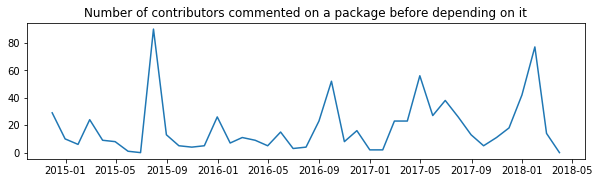

In [7]:
plt.rcParams["figure.figsize"] = (10,2.5)
fig, ax = plt.subplots()
ax.plot(df_data.groupby(pandas.Grouper(key='first_time',freq='1M'))['Number_of_contributors'].sum())
ax.set_title('Number of contributors commented on a package before depending on it')
plt.show()

#### Number of packages with contributors who have had commenting activity before depending on package

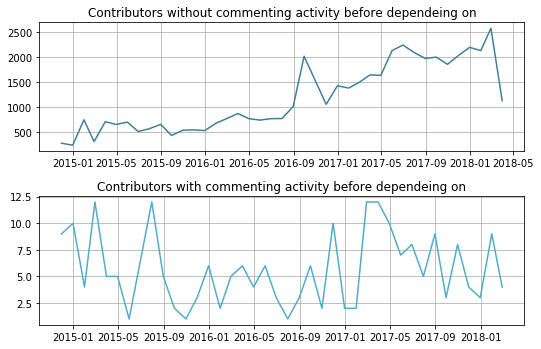

In [10]:
df_tmp_proportion = (
    df_data
    .assign(Number_of_contributors = lambda x: np.where(x['Number_of_contributors']>0,1,0))
    .assign(count = 1)
    .groupby([pandas.Grouper(key='first_time',freq='1M'),'package','target','Number_of_contributors'])
    .sum()
    .reset_index()
    .assign(contributors_count = 1)
    .groupby([pandas.Grouper(key='first_time',freq='1M'),'Number_of_contributors'])
    .sum()
    .reset_index()
)
plt.rcParams["figure.figsize"] = (16,5)
dic = {1:'Contributors with commenting activity before dependeing on',0:'Contributors without commenting activity before dependeing on'}
plt.figure(1)
i = 221
for item in df_tmp_proportion.Number_of_contributors.unique():
    plt.subplot(i)
    plt.plot(df_tmp_proportion[lambda x: x['Number_of_contributors'] == item]['first_time'],df_tmp_proportion[lambda x: x['Number_of_contributors'] == item]['contributors_count'],color=palet2[i-219])
    plt.title(dic[item])
    plt.grid(True)
    i+=2
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.02)

#### Proportions of comments regarding type of comment contribution and contributor type over time

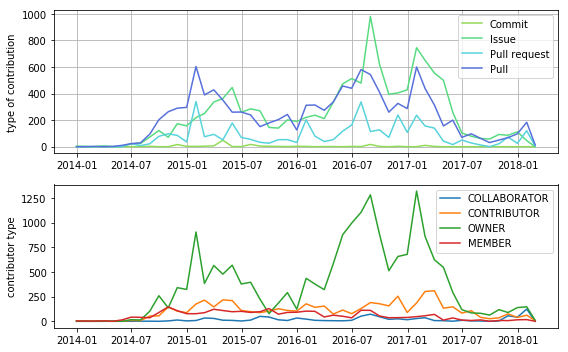

In [8]:
df_cntb_cmnt_plot = (
    cntb_cmnts[['created_at','author_assoc','type']]
    .assign(count=1)
    .groupby([pandas.Grouper(key='created_at',freq='1M'),'type'])
    .sum()
    .unstack('type')
    .fillna(0).rename(columns={'cmt': 'Commit',
                               'pul': 'Pull',
                               'isu': 'Issue',
                               'prq': 'Pull request'})
)

df_cntb_cmnt_plot2 = (
    cntb_cmnts[['created_at','author_assoc','type']]
    .assign(count=1)
    .groupby([pandas.Grouper(key='created_at',freq='1M'),'author_assoc'])
    .sum()
    .unstack('author_assoc')
    .fillna(0)
)

plt.rcParams["figure.figsize"] = (8,5)
fig, axs = plt.subplots(2, 1)

df_cntb_cmnt_plot = df_cntb_cmnt_plot.xs('count', axis=1, drop_level=True).reset_index()
for i in range(1,len(df_cntb_cmnt_plot.columns)):
    axs[0].plot(df_cntb_cmnt_plot['created_at'],df_cntb_cmnt_plot[df_cntb_cmnt_plot.columns[i]],color= palet[i+1])

axs[0].set_ylabel('type of contribution')
axs[0].grid(True)
axs[0].legend(('Commit','Issue','Pull request','Pull'))
axs[1].plot(df_cntb_cmnt_plot2)
axs[1].set_ylabel('contributor type')
axs[1].legend(('COLLABORATOR','CONTRIBUTOR','OWNER','MEMBER'))

fig.tight_layout()
plt.show()

In [9]:
cntb_cmnts = (
    cntb_cmnts
    .reset_index()
    .drop('level_0',axis=1)
)
cntb_cmnts.head()

,index,Name,user_login,author_assoc,created_at,type
0,3328,mio,guanqun,CONTRIBUTOR,2017-08-02 01:39:37,isu
1,4918,mio,guanqun,CONTRIBUTOR,2017-06-27 23:46:28,pul
2,4919,mio,guanqun,CONTRIBUTOR,2017-07-01 15:39:13,pul
3,4921,mio,guanqun,CONTRIBUTOR,2017-07-02 02:09:20,pul
4,4923,mio,guanqun,CONTRIBUTOR,2017-07-26 09:03:52,pul


In [11]:
#finding first-time contributor start depending on a package and adding it to the corresponding comment 
def find_depend_data(index):
    index_of_cmnt = -1
    for id, row in df_data.dropna().iterrows():
        if index in row['comments_id']:
            index_of_cmnt = id
            break
    return df_data.loc[id]['first_time'] 
    
cntb_cmnts['time_of_package'] = cntb_cmnts.apply(lambda r: find_depend_data(r['index']),axis=1)
cntb_cmnts['time_diff'] = cntb_cmnts.apply(lambda r: (r['time_of_package']- r['created_at']).total_seconds()/3600/24/7,axis=1)
cntb_cmnts['year'] = cntb_cmnts.apply(lambda r: r['created_at'].year,axis=1)
cntb_cmnts_sorted = cntb_cmnts.sort_values('year')
cntb_cmnts_sorted.head()

,index,Name,user_login,author_assoc,created_at,type,time_of_package,time_diff,year
1971,28417,openssl,sfackler,OWNER,2013-12-30 23:12:56,isu,2016-09-29 18:26:29,143.400154,2013
9207,28419,openssl,sfackler,OWNER,2013-12-30 00:36:29,isu,2016-09-29 18:26:29,143.534722,2013
9206,28417,openssl,sfackler,OWNER,2013-12-30 23:12:56,isu,2016-09-29 18:26:29,143.400154,2013
1972,28419,openssl,sfackler,OWNER,2013-12-30 00:36:29,isu,2016-09-29 18:26:29,143.534722,2013
18837,73528,hyper,seanmonstar,MEMBER,2014-11-17 05:26:32,pul,2016-10-16 17:29:41,99.928884,2014


#### A box plot to show time interval between start commenting activity on a package and start depending on it.

[Text(0, 0.5, 'Time Interval'),
 Text(0.5, 0, 'Time Interval between start commenting on a package and start using it')]

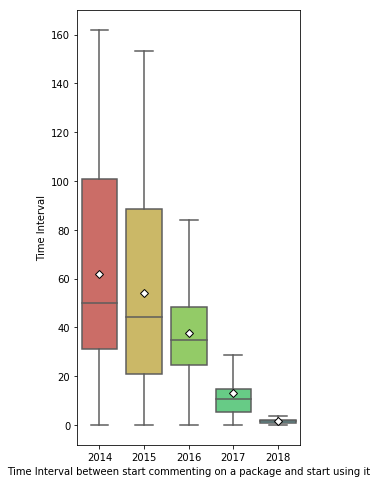

In [12]:
plt.rcParams["figure.figsize"] = (4,8)
fig, ax = plt.subplots()

seaborn.boxplot(
    x='year', 
    y='time_diff', 
    data=(
        cntb_cmnts_sorted[['year','time_diff']]
    ),
    order=range(2014, 2019),
    palette=palet,
    ax=ax,
    fliersize=1,
    showmeans=True,
    showfliers=False,
    meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='white')
)

ax.set(
    xlabel='Time Interval between start commenting on a package and start using it', 
    ylabel='Time Interval'
)

#### Time interval between start commenting activity on a package and start depending on it according to type of comment

[Text(0, 0.5, 'Time Interval'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Time interval between start commenting activity on a package and start depending on it')]

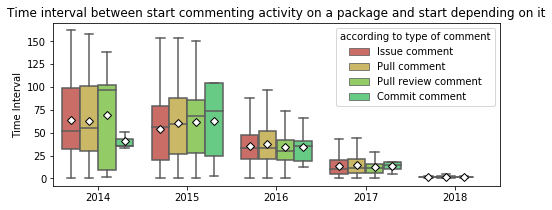

In [72]:
plt.rcParams["figure.figsize"] = (8,3)
fig, ax = plt.subplots()
types = {'isu':'Issue comment','pul':'Pull comment','prq':'Pull review comment','cmt':'Commit comment'}
seaborn.boxplot(
    x='year', 
    y='time_diff', 
    hue='type',
    data=(
        cntb_cmnts_sorted[['year','time_diff','type']]
        .groupby(['year','time_diff','type'])
        .sum()
        .reset_index()
        .assign(type= lambda x: x['type'].map(types))
    ),
    order=range(2014, 2019),
    palette=palet,
    ax=ax,
    fliersize=1,
    showmeans=True,
    showfliers=False,
    meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='white')
)
ax.legend(title='according to type of comment')
ax.set(
    title='Time interval between start commenting activity on a package and start depending on it',
    ylabel= 'Time Interval',
    xlabel=''
)

In [13]:
df_data['time_to_come'] = df_data.apply(lambda x: (x['first_time'] - x['fst_release']).total_seconds()/3600/24 ,axis=1)
df_data['cntrcmnted'] = df_data.apply(lambda x: 1 if x['Number_of_contributors']>0 else 0,axis=1)

In [16]:
dfwithcont = df_data[df_data.comments_id.notnull()]

Creating a dataframe with all comments (those ended up with start depending on a package and those didn't)

In [36]:
comments_on_packages = (
    cntb_cmnts
    .drop('index',axis=1)
    .merge(all_comments,how='outer',
           left_on=['Name','user_login','author_assoc','created_at','type'],
           right_on=['Name','user_login','author_assoc','created_at','type'])
)
comments_on_packages.head()

,Name,user_login,author_assoc,created_at,type,time_of_package,time_diff,year
0,mio,guanqun,CONTRIBUTOR,2017-08-02 01:39:37,isu,2017-09-25 16:26:55,7.802312,2017.0
1,mio,guanqun,CONTRIBUTOR,2017-06-27 23:46:28,pul,2017-09-25 16:26:55,12.813537,2017.0
2,mio,guanqun,CONTRIBUTOR,2017-07-01 15:39:13,pul,2017-09-25 16:26:55,12.290446,2017.0
3,mio,guanqun,CONTRIBUTOR,2017-07-02 02:09:20,pul,2017-09-25 16:26:55,12.227935,2017.0
4,mio,guanqun,CONTRIBUTOR,2017-07-26 09:03:52,pul,2017-09-25 16:26:55,8.758239,2017.0


According to lifelines instruction we use the date contributor started to comment as start_date and the date they start depending on the package as end_date. We used datetimes_to_durations of lifelines.utils to generate T and E series

In [37]:
from lifelines.utils import datetimes_to_durations
T, E = datetimes_to_durations(comments_on_packages['created_at'], comments_on_packages['time_of_package'], fill_date='2018-06-01')

In [66]:
plt.rcParams["figure.figsize"] = (8,5)
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter: fitted with 136668 observations, 108507 censored>

#### We used KaplanMeierFitter to calculate the probability of depending on a package after start commenting on it.

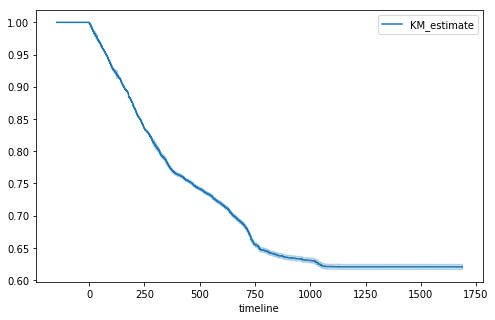

In [67]:
kmf.plot()

#### probability of depending on a package according type of comment contribution

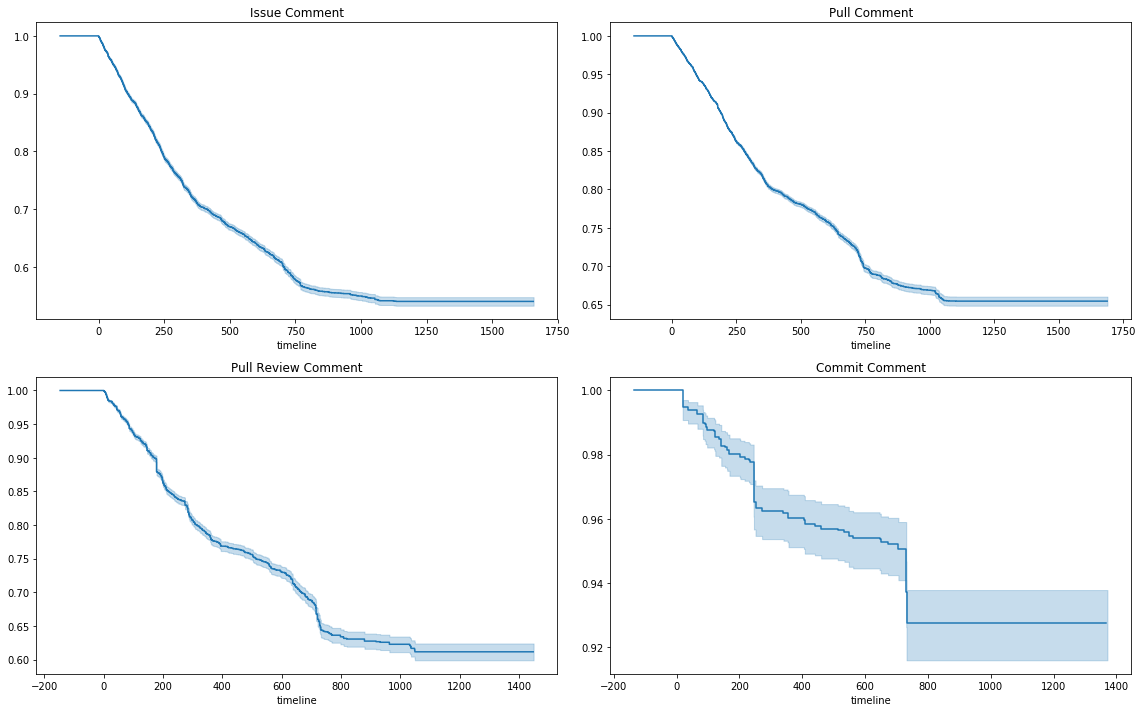

In [68]:
plt.rcParams["figure.figsize"] = (16,10)

types = {'isu':'Issue Comment','pul':'Pull Comment','prq':'Pull Review Comment','cmt':'Commit Comment'}
cmtypes = comments_on_packages['type'].unique()

for i,cmtype in enumerate(cmtypes):
    ax = plt.subplot(2,2, i+1)
    ix = comments_on_packages['type'] == cmtype
    kmf.fit( T[ix], E[ix], label=cmtype)
    kmf.plot(ax=ax, legend=False)
    plt.title(types[cmtype])

plt.tight_layout()